In [2]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
    ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [40]:
df = pd.read_csv('weatherAUS.csv')
df.shape

cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
df = df[cols]

df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
df = df.dropna(how='any')
# print(df['RainTomorrow'][10:100])
# sns.countplot(x=df['RainTomorrow']);


In [61]:
df.RainTomorrow.value_counts() / df.shape[0]
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


In [48]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [50]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [51]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 1.436, accuracy: 0.221
Test  set - loss: 1.44, accuracy: 0.222

epoch 100
Train set - loss: 0.644, accuracy: 0.779
Test  set - loss: 0.644, accuracy: 0.778

epoch 200
Train set - loss: 0.624, accuracy: 0.779
Test  set - loss: 0.624, accuracy: 0.778

epoch 300
Train set - loss: 0.606, accuracy: 0.779
Test  set - loss: 0.607, accuracy: 0.778

epoch 400
Train set - loss: 0.592, accuracy: 0.779
Test  set - loss: 0.592, accuracy: 0.778

epoch 500
Train set - loss: 0.579, accuracy: 0.779
Test  set - loss: 0.58, accuracy: 0.778

epoch 600
Train set - loss: 0.569, accuracy: 0.779
Test  set - loss: 0.57, accuracy: 0.778

epoch 700
Train set - loss: 0.56, accuracy: 0.779
Test  set - loss: 0.561, accuracy: 0.778

epoch 800
Train set - loss: 0.553, accuracy: 0.779
Test  set - loss: 0.554, accuracy: 0.779

epoch 900
Train set - loss: 0.548, accuracy: 0.779
Test  set - loss: 0.548, accuracy: 0.779



In [62]:
MODEL_PATH = 'model_01.pth'
torch.save(net, MODEL_PATH)
net = torch.load(MODEL_PATH)

In [53]:
classes = ['No rain', 'Raining']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.78      1.00      0.88     19413
     Raining       0.63      0.01      0.03      5525

    accuracy                           0.78     24938
   macro avg       0.70      0.51      0.45     24938
weighted avg       0.75      0.78      0.69     24938



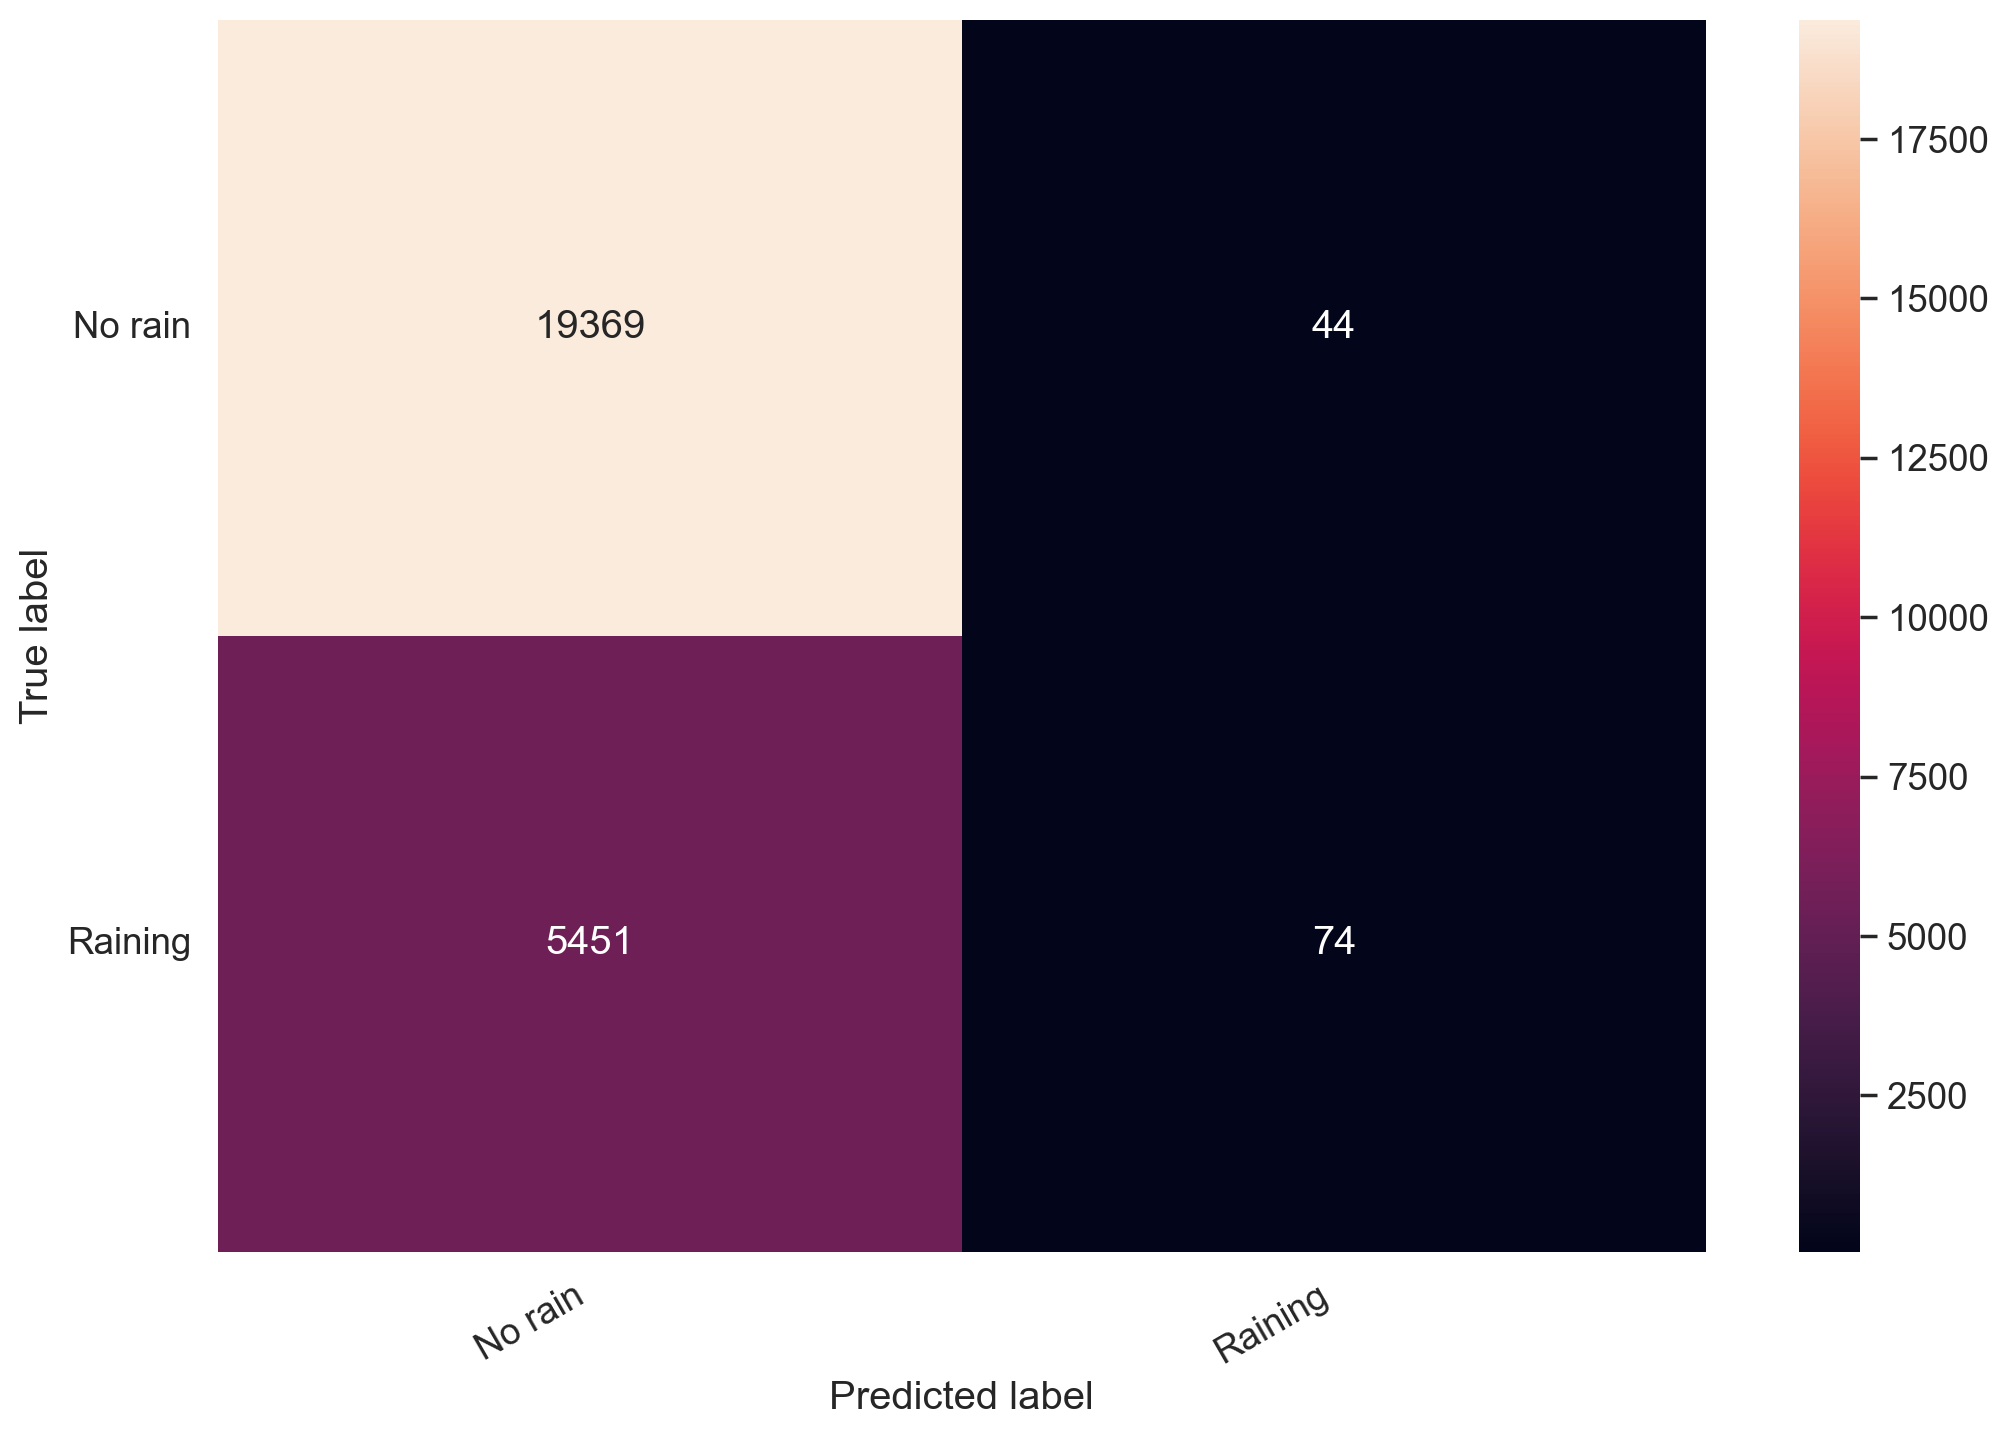

In [54]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [59]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

print(will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2))

will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

False


False